# Using behavioural theories in the knowledge extraction from the energy consumption of private households

In [1]:
import pickle
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import keras
import tensorflow as tf
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
with open('preprocessed_merged_Acorn.pkl','rb') as path_name:
   acorn = pickle.load(path_name)

# Preparation of the target variables for the models

In [3]:
# daily median per Acorn group
acorn_daily_agg = acorn.groupby(['Acorn','Date']).agg(
    daily_acorn_median = pd.NamedAgg(column='energy_sum', aggfunc='median'))

In [4]:
# Merge 
merged_df = acorn.merge(acorn_daily_agg, how='inner', left_on=["Acorn", "Date"], right_on=["Acorn","Date"])

In [5]:
aggdata = merged_df.groupby(['Acorn','stdorToU'])['energy_sum'].agg('mean').reset_index()
aggdata = aggdata.set_index(['Acorn','stdorToU']).unstack(['stdorToU'])
aggdata = aggdata.reset_index()
aggdata = aggdata.set_axis(['Acorn', 'Std','ToU'], axis=1)

# percantage difference between Std and Tou per Acorn group
aggdata['difference'] = ((aggdata['ToU']-aggdata['Std'])/aggdata['ToU'])*100

# mean difference between Std and ToU
#aggdata.difference.mean()
aggdata


,Acorn,Std,ToU,difference
0,ACORN-A,18.514585,15.497825,-19.465704
1,ACORN-C,12.078115,10.123228,-19.310909
2,ACORN-D,13.048999,12.097414,-7.866018
3,ACORN-E,10.223494,9.123929,-12.051437
4,ACORN-F,9.248979,8.583654,-7.751060
5,ACORN-G,10.353235,8.691221,-19.122906
6,ACORN-H,11.025550,9.999328,-10.262913
7,ACORN-K,10.133907,10.102431,-0.311569
8,ACORN-L,10.129704,8.826501,-14.764658
9,ACORN-N,9.140372,9.100845,-0.434322


In [6]:
# Difference to median energy consumption
merged_df['difference_median_energyConsumption'] = merged_df['energy_sum']-merged_df['daily_acorn_median']

In [7]:
# Get a column for year, month, day 
merged_df['year'] = merged_df['Date'].dt.year
merged_df['month'] = merged_df['Date'].dt.month
merged_df['day'] = merged_df['Date'].dt.day

In [8]:
# Apply messages for intentions and knowledge action gap
conditions = [
    merged_df['energy_sum'] < merged_df['daily_acorn_median'],
    merged_df['Acorn'].eq('ACORN-C') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-F') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-G') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-H') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std')),
    merged_df['Acorn'].eq('ACORN-A') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-D') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-E') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std'))|
    merged_df['Acorn'].eq('ACORN-K') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])& (merged_df['stdorToU'].eq('Std')),
    merged_df['Acorn'].eq('ACORN-C') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-F') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-G') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-H') & (merged_df['energy_sum']>merged_df['daily_acorn_median']),
    merged_df['Acorn'].eq('ACORN-A') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-D') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-E') & (merged_df['energy_sum']>merged_df['daily_acorn_median'])|
    merged_df['Acorn'].eq('ACORN-K') & (merged_df['energy_sum']>merged_df['daily_acorn_median']),
    merged_df['stdorToU'].eq('Std') & (merged_df['energy_sum']>merged_df['daily_acorn_median']),  
    merged_df['energy_sum'] >= merged_df['daily_acorn_median'],
    ]
values = [1,2,3,4,5,6,7]

merged_df['message'] = np.select(conditions, values)
merged_df['message'] = merged_df['message'].astype('category')

In [9]:
# Apply new energy consumption

merged_df['new_Energy_Consumption'] = np.where(merged_df['message'] != 1, 
                                               merged_df['energy_sum']-merged_df['energy_sum']/100*6.3, 
                                               merged_df['energy_sum']) 
merged_df['new_Energy_Consumption'] = np.where(merged_df['message'] == 2, 
                                               merged_df['energy_sum']-merged_df['energy_sum']/100*10.7,merged_df['new_Energy_Consumption'])  
merged_df['new_Energy_Consumption'] = np.where(merged_df['message'] == 3, 
                                               merged_df['energy_sum']-merged_df['energy_sum']/100*10.7,merged_df['new_Energy_Consumption'])
merged_df['new_Energy_Consumption'] = np.where(merged_df['message'] == 6, 
                                               merged_df['energy_sum']-merged_df['energy_sum']/100*10.7,merged_df['new_Energy_Consumption'])  

In [10]:
# Coins
merged_df['coins'] =np.where(merged_df['difference_median_energyConsumption'] >= 0, 0, 1 )

# Create Coin account

acorn_coin_agg = merged_df.groupby(['Acorn','month','LCLid']).agg(
    CoinAccount = pd.NamedAgg(column='coins', aggfunc='count'))
acorn_coin_agg.reset_index(inplace=True) # reset index
acorn_coin_agg =acorn_coin_agg.loc[~(acorn_coin_agg==0).all(axis=1)]
merged_df = pd.merge( merged_df, acorn_coin_agg, how='inner', on =['LCLid','month','Acorn']) 

In [11]:
cond =[(merged_df['CoinAccount'] >= 30),
       (merged_df['CoinAccount'] >= 15 )& (merged_df['CoinAccount']< 30),]

value=[1,2]

merged_df['messageCoins'] = np.select(cond, value)
merged_df['messageCoins'] = merged_df['messageCoins'].astype('category')



In [12]:
merged_df = merged_df.drop(columns=(['coins', 'Acorn_grouped','Date','daily_acorn_median']))

In [13]:
preprocessed = merged_df.copy()

In [14]:
# LCLid cut
preprocessed['LCLid'] = preprocessed['LCLid'].str.replace('MAC', '')
# change datatype
preprocessed['LCLid'] =preprocessed['LCLid'].astype('int')

In [15]:
preprocessed['LCLid'] = preprocessed['LCLid'].astype('int')
preprocessed['message'] = preprocessed['message'].astype('int')

In [16]:
# Dummy coding: Acorn, stdorToU
preprocessed = pd.get_dummies(preprocessed, prefix_sep="_", columns=['Acorn'], drop_first=True)
preprocessed = pd.get_dummies(preprocessed, prefix_sep="_", columns=['stdorToU'], drop_first=True)

In [17]:
preprocessed.head()

,LCLid,energy_sum,difference_median_energyConsumption,year,month,day,message,new_Energy_Consumption,CoinAccount,messageCoins,...,Acorn_ACORN-D,Acorn_ACORN-E,Acorn_ACORN-F,Acorn_ACORN-G,Acorn_ACORN-H,Acorn_ACORN-K,Acorn_ACORN-L,Acorn_ACORN-N,Acorn_ACORN-Q,stdorToU_ToU
0,2,10.800,-6.387000,2013,1,1,1,10.800,31,1,...,0,0,0,0,0,0,0,0,0,0
1,2,13.300,-4.148999,2013,1,2,1,13.300,31,1,...,0,0,0,0,0,0,0,0,0,0
2,2,10.074,-6.401999,2013,1,3,1,10.074,31,1,...,0,0,0,0,0,0,0,0,0,0
3,2,9.857,-7.017000,2013,1,4,1,9.857,31,1,...,0,0,0,0,0,0,0,0,0,0
4,2,11.171,-7.076000,2013,1,5,1,11.171,31,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# For better training of the model the numeric variables are being standardized 
scaler = StandardScaler()  

X = preprocessed.select_dtypes(include='float32')  # extract numeric variables
X_new = scaler.fit_transform(X)  # perform the scaling
X_new = pd.DataFrame(X_new, columns = X.columns)  # convert result into a data frame
preprocessed[X.columns] = X_new

preprocessed.head(10)

,LCLid,energy_sum,difference_median_energyConsumption,year,month,day,message,new_Energy_Consumption,CoinAccount,messageCoins,...,Acorn_ACORN-D,Acorn_ACORN-E,Acorn_ACORN-F,Acorn_ACORN-G,Acorn_ACORN-H,Acorn_ACORN-K,Acorn_ACORN-L,Acorn_ACORN-N,Acorn_ACORN-Q,stdorToU_ToU
0,2,0.109158,-1.088966,2013,1,1,1,10.800,31,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0.426221,-0.791511,2013,1,2,1,13.300,31,1,...,0,0,0,0,0,0,0,0,0,0
2,2,0.017083,-1.090960,2013,1,3,1,10.074,31,1,...,0,0,0,0,0,0,0,0,0,0
3,2,-0.010438,-1.172700,2013,1,4,1,9.857,31,1,...,0,0,0,0,0,0,0,0,0,0
4,2,0.156210,-1.180542,2013,1,5,1,11.171,31,1,...,0,0,0,0,0,0,0,0,0,0
5,2,0.044858,-1.373795,2013,1,6,1,10.293,31,1,...,0,0,0,0,0,0,0,0,0,0
6,2,-0.063451,-1.216029,2013,1,7,1,9.439,31,1,...,0,0,0,0,0,0,0,0,0,0
7,2,0.215691,-0.778220,2013,1,8,1,11.640,31,1,...,0,0,0,0,0,0,0,0,0,0
8,2,0.674671,-0.420024,2013,1,9,1,15.259,31,1,...,0,0,0,0,0,0,0,0,0,0
9,2,0.101549,-0.983833,2013,1,10,1,10.740,31,1,...,0,0,0,0,0,0,0,0,0,0


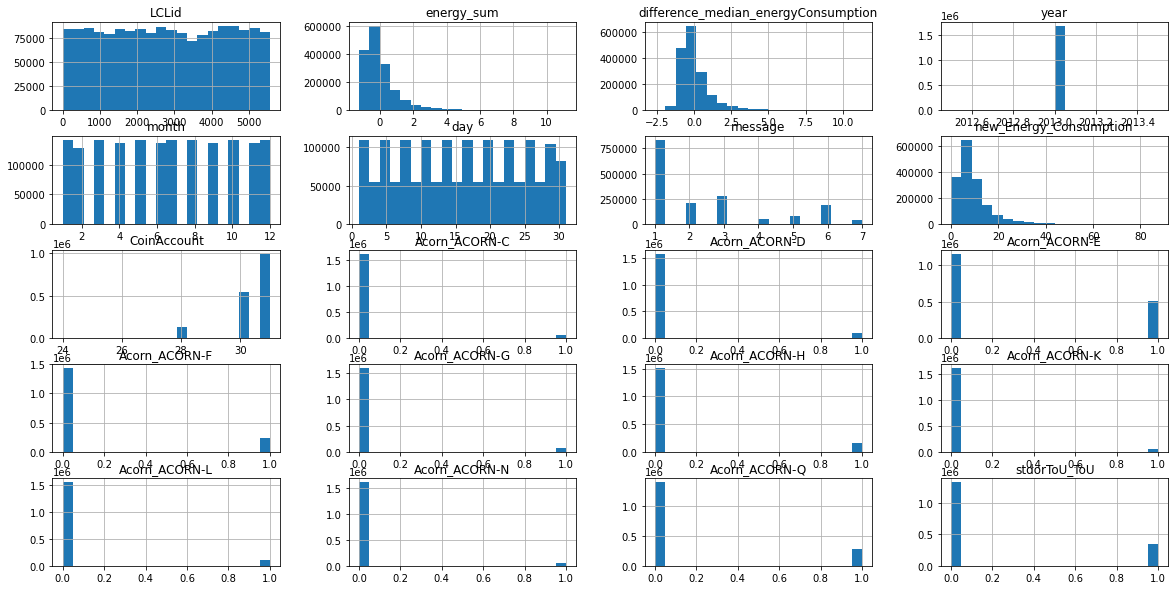

In [19]:
# the history bins show how the data is distributed among the variables
plt.rcParams["figure.figsize"] = (20,10)
preprocessed.select_dtypes(exclude='bool').hist(bins=20);

# The Models

## Model 1 "Message"

In [20]:
encoder = LabelEncoder()
encoder.fit(preprocessed["message"])
dummy_y = np_utils.to_categorical(encoder.transform(preprocessed["message"]))
dummy_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
# depart the dataframe into target variable and covariates
y = dummy_y.astype(int)
X = preprocessed.drop(columns=(['message','messageCoins']), axis=1)

In [22]:
seed=32

In [23]:
# Splitting the data into train and test set
# The training set is used to train the model and the test set is used to predict and 
# evaluate the model after the training is done
# For this the dataset is split into X -> all variables but the target variable
# and y -> target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# see how the vectors look like
y_train.shape, y_test.shape, X_train.shape, X_train.shape

print (X_train.shape)
print(y_train.shape) 
X.head(5)

(1329944, 19)
(1329944, 7)


,LCLid,energy_sum,difference_median_energyConsumption,year,month,day,new_Energy_Consumption,CoinAccount,Acorn_ACORN-C,Acorn_ACORN-D,Acorn_ACORN-E,Acorn_ACORN-F,Acorn_ACORN-G,Acorn_ACORN-H,Acorn_ACORN-K,Acorn_ACORN-L,Acorn_ACORN-N,Acorn_ACORN-Q,stdorToU_ToU
0,2,0.109158,-1.088966,2013,1,1,10.800,31,0,0,0,0,0,0,0,0,0,0,0
1,2,0.426221,-0.791511,2013,1,2,13.300,31,0,0,0,0,0,0,0,0,0,0,0
2,2,0.017083,-1.090960,2013,1,3,10.074,31,0,0,0,0,0,0,0,0,0,0,0
3,2,-0.010438,-1.172700,2013,1,4,9.857,31,0,0,0,0,0,0,0,0,0,0,0
4,2,0.156210,-1.180542,2013,1,5,11.171,31,0,0,0,0,0,0,0,0,0,0,0


In [25]:
nb_units = 128

#set up a model called model of type sequential
model = Sequential()

# Adding the layers
model.add(Dense(nb_units,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed),  #initialisation of weights
                bias_initializer='zeros', #initialization of biases
                input_shape=(X.shape[1],))) # size of the first hidden layer
# Second layer with the same configuration 
model.add(Dense(nb_units, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), bias_initializer='zeros')) 

# Output layer
nb_classes = y.shape[1]
model.add(Dense(nb_classes, activation='softmax', kernel_initializer=keras.initializers.he_normal(seed=seed), bias_initializer='zeros')) 

# Show the model architecture 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 19,975
Trainable params: 19,975
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compiling the model using Adams as optimizer and categorical crossentropy as loss-function
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
batch_size = 56 
epochs = 30
cb=EarlyStopping(monitor='val_loss', min_delta=0.1, verbose=0, patience=10, restore_best_weights=True) 

# Train the model
story = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.3, 
                    callbacks=[cb]
                 )

Epoch 1/30
16625/16625 - 16s - loss: 7.1333 - accuracy: 0.6748 - val_loss: 0.6012 - val_accuracy: 0.8301
Epoch 2/30
16625/16625 - 17s - loss: 0.3400 - accuracy: 0.8855 - val_loss: 0.3011 - val_accuracy: 0.8760
Epoch 3/30
16625/16625 - 18s - loss: 0.2062 - accuracy: 0.9286 - val_loss: 0.0990 - val_accuracy: 0.9676
Epoch 4/30
16625/16625 - 23s - loss: 0.1348 - accuracy: 0.9525 - val_loss: 0.2240 - val_accuracy: 0.9206
Epoch 5/30
16625/16625 - 20s - loss: 0.1046 - accuracy: 0.9651 - val_loss: 0.0351 - val_accuracy: 0.9929
Epoch 6/30
16625/16625 - 18s - loss: 0.0873 - accuracy: 0.9724 - val_loss: 0.0962 - val_accuracy: 0.9690
Epoch 7/30
16625/16625 - 19s - loss: 0.0739 - accuracy: 0.9771 - val_loss: 0.0534 - val_accuracy: 0.9813
Epoch 8/30
16625/16625 - 19s - loss: 0.0606 - accuracy: 0.9815 - val_loss: 0.1347 - val_accuracy: 0.9551
Epoch 9/30
16625/16625 - 19s - loss: 0.0533 - accuracy: 0.9845 - val_loss: 0.1695 - val_accuracy: 0.9526
Epoch 10/30
16625/16625 - 17s - loss: 0.0459 - accuracy

In [28]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09857404232025146
Test accuracy: 0.9673279523849487


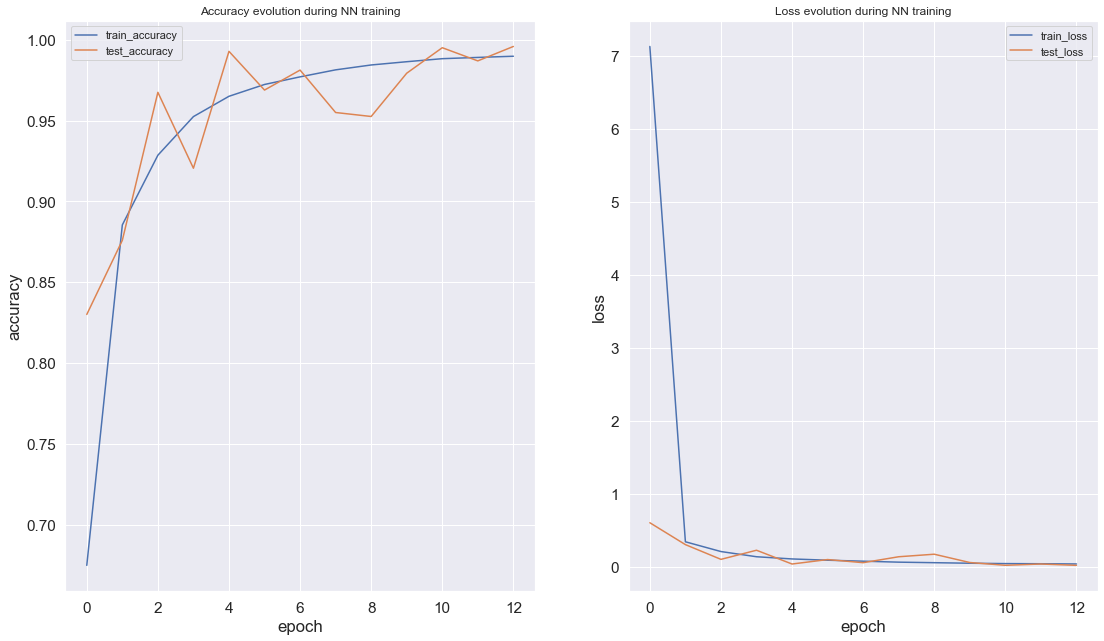

In [53]:
# Show the process of accuracy and loss while training the model
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    sns.set(style="darkgrid")
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()

show_history(story)


### Model prediction and evaluation

In [30]:
# Compute predictions
yhat = model.predict(X_test)
yhat.shape

(332486, 7)

In [31]:
# Finding the most probable class
yhat_c = np.argmax(yhat, axis=1)
print(yhat_c)

[0 0 0 ... 5 0 0]


In [32]:
pd.crosstab(index=preprocessed["message"],columns="count")

col_0,count
message,
1,829857
2,205003
3,281253
4,49015
5,73460
6,187621
7,36221


In [33]:
# Show the classification report
target_names = ["Message 1","Message 3","Message 3","Message 4","Message 5","Message 6","Message 7"]
true_label = np.argmax(y_test,axis = 1)
print ('\nClassification report:\n', classification_report(true_label, yhat_c, target_names=target_names))


Classification report:
               precision    recall  f1-score   support

   Message 1       0.95      0.99      0.97    166208
   Message 3       0.99      0.96      0.97     40785
   Message 3       0.98      0.97      0.98     56302
   Message 4       1.00      0.85      0.91      9750
   Message 5       0.98      0.93      0.96     14862
   Message 6       1.00      0.96      0.98     37403
   Message 7       1.00      0.69      0.82      7176

    accuracy                           0.97    332486
   macro avg       0.98      0.91      0.94    332486
weighted avg       0.97      0.97      0.97    332486



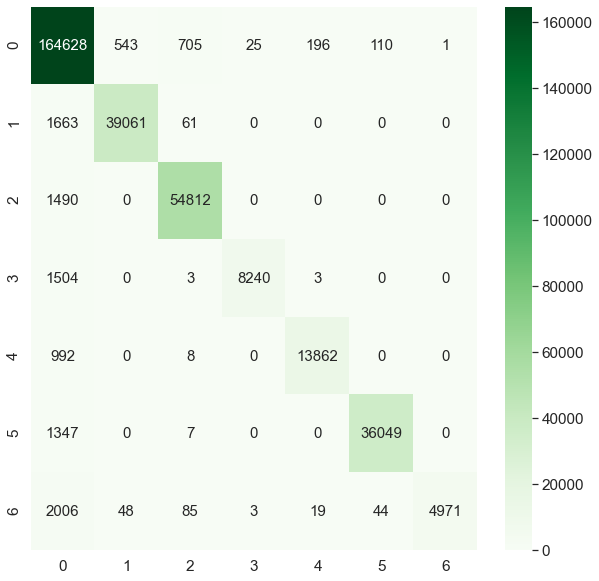

In [34]:
# Show the confusion matrix

conf= confusion_matrix(true_label, yhat_c)

df_cm = pd.DataFrame(conf, range(7), range(7))
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g',cmap="Greens") # font size
#plt.savefig('message_heatmap.png')
plt.show()

In [35]:
ypred = model.predict(X_train)
ypred = ypred.argmax(axis=-1)
ypred


ytrain = y_train.argmax(axis=-1)
ytrain


array([0, 0, 2, ..., 0, 0, 0], dtype=int64)

ROC AUC score: 0.949694812945649


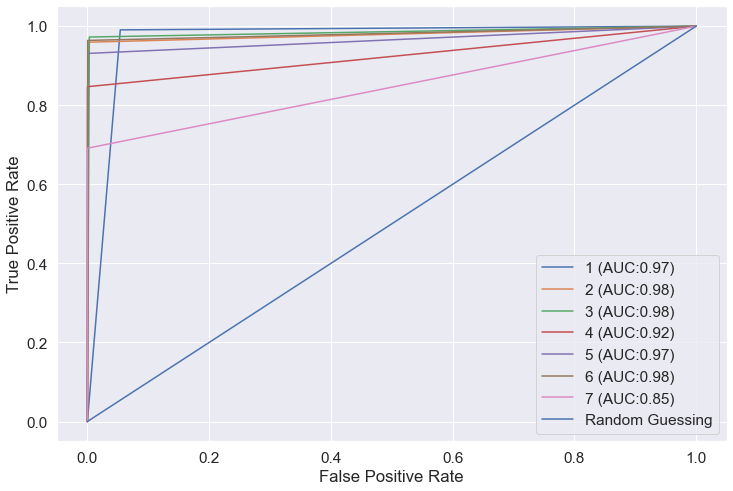

In [36]:
# Calculate ROC curve

target= [1,2,3,4,5,6,7]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

plt.show()


# Model 2 "Coins"

In [37]:
encoder = LabelEncoder()
encoder.fit(preprocessed["messageCoins"])
dummy_y1 = np_utils.to_categorical(encoder.transform(preprocessed["messageCoins"]))
dummy_y1

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [38]:
# depart the dataframe into target variable and covariates
y1 = dummy_y1.astype(int)
X1 = preprocessed.drop(columns=(['messageCoins','message']), axis=1)

In [39]:
# Splitting the data into train and test set
# The training set is used to train the model and the test set is used to predict and 
# evaluate the model after the training is done
# For this the dataset is split into X -> all variables but the target variable
# and y -> target variable

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=seed)

# see how the vectors look like
y1_train.shape, y1_test.shape, X1_train.shape, X1_train.shape

print (X1_train.shape)
print(y1_train.shape) 
X.head(5)

(1329944, 19)
(1329944, 2)


,LCLid,energy_sum,difference_median_energyConsumption,year,month,day,new_Energy_Consumption,CoinAccount,Acorn_ACORN-C,Acorn_ACORN-D,Acorn_ACORN-E,Acorn_ACORN-F,Acorn_ACORN-G,Acorn_ACORN-H,Acorn_ACORN-K,Acorn_ACORN-L,Acorn_ACORN-N,Acorn_ACORN-Q,stdorToU_ToU
0,2,0.109158,-1.088966,2013,1,1,10.800,31,0,0,0,0,0,0,0,0,0,0,0
1,2,0.426221,-0.791511,2013,1,2,13.300,31,0,0,0,0,0,0,0,0,0,0,0
2,2,0.017083,-1.090960,2013,1,3,10.074,31,0,0,0,0,0,0,0,0,0,0,0
3,2,-0.010438,-1.172700,2013,1,4,9.857,31,0,0,0,0,0,0,0,0,0,0,0
4,2,0.156210,-1.180542,2013,1,5,11.171,31,0,0,0,0,0,0,0,0,0,0,0


In [42]:
#set up a model called model1 of type sequential
model1 = Sequential()

# Adding the layers
model1.add(Dense(nb_units,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed),  #initialisation of weights
                bias_initializer='zeros', #initialization of biases
                input_shape=(X1.shape[1],))) # size of the first hidden layer
# Second layer with the same configuration 
model1.add(Dense(nb_units, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), bias_initializer='zeros')) 

# Output layer
nb_classes = y1.shape[1]
model1.add(Dense(nb_classes, activation='softmax', kernel_initializer=keras.initializers.he_normal(seed=seed), bias_initializer='zeros')) 

# Show the model architecture 
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               2560      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 19,330
Trainable params: 19,330
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compiling the model using Adams as optimizer and categorical crossentropy as loss-function
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
cb=EarlyStopping(monitor='val_loss', min_delta=0.1, verbose=0, patience=10, restore_best_weights=True) 

# Train the model
story1 = model1.fit(X1_train, y1_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.3,
                    callbacks=[cb]
                 )

Epoch 1/30
16625/16625 - 17s - loss: 3.2697 - accuracy: 0.8924 - val_loss: 0.1279 - val_accuracy: 0.9406
Epoch 2/30
16625/16625 - 20s - loss: 0.1465 - accuracy: 0.9546 - val_loss: 0.0518 - val_accuracy: 0.9852
Epoch 3/30
16625/16625 - 20s - loss: 0.0599 - accuracy: 0.9835 - val_loss: 0.0503 - val_accuracy: 0.9810
Epoch 4/30
16625/16625 - 19s - loss: 0.0304 - accuracy: 0.9937 - val_loss: 0.0077 - val_accuracy: 0.9992
Epoch 5/30
16625/16625 - 18s - loss: 0.0259 - accuracy: 0.9950 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 6/30
16625/16625 - 17s - loss: 0.0196 - accuracy: 0.9964 - val_loss: 0.0141 - val_accuracy: 0.9991
Epoch 7/30
16625/16625 - 17s - loss: 0.0198 - accuracy: 0.9963 - val_loss: 0.0107 - val_accuracy: 0.9992
Epoch 8/30
16625/16625 - 17s - loss: 0.0160 - accuracy: 0.9971 - val_loss: 0.0087 - val_accuracy: 0.9992
Epoch 9/30
16625/16625 - 17s - loss: 0.0170 - accuracy: 0.9969 - val_loss: 0.0052 - val_accuracy: 0.9993
Epoch 10/30
16625/16625 - 19s - loss: 0.0142 - accuracy

In [45]:
# Evaluation of the model
score1 = model1.evaluate(X1_test, y1_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.007559109013527632
Test accuracy: 0.9992240071296692


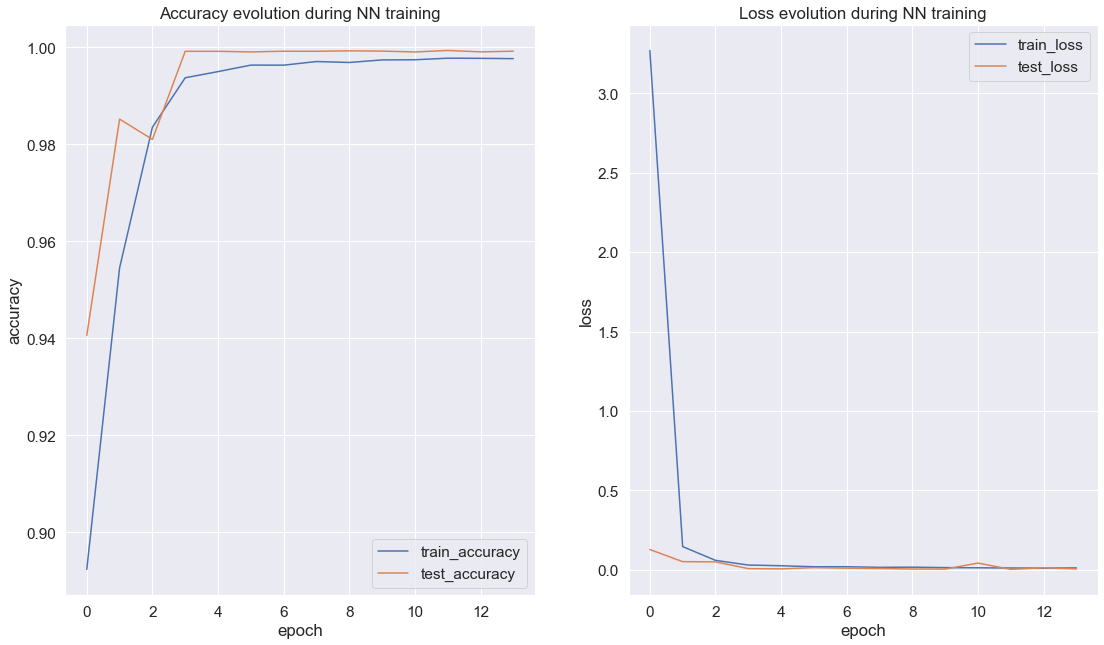

In [46]:
# Show the process of accuracy and loss while training the model
def show_history(story1):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story1.history['accuracy'])
    ax1.plot(story1.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story1.history['loss'])
    ax2.plot(story1.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
 
    plt.show()

show_history(story1)


### Model prediction and evaluation

In [47]:
# Compute predictions
yhat1 = model1.predict(X1_test)
yhat1.shape

(332486, 2)

In [48]:
# Finding the most probable class
yhat_c1 = np.argmax(yhat1, axis=1)
print(yhat_c)

[0 0 0 ... 5 0 0]


In [49]:
pd.crosstab(index=preprocessed['messageCoins'],columns="count")

col_0,count
messageCoins,
1,1533328
2,129102


In [50]:
# Show the classification report
target_names1 = ["Grade 0","Grade 1"]
true_label1 = np.argmax(y1_test,axis = 1)
print ('\nClassification report:\n', classification_report(true_label1, yhat_c1, target_names=target_names1))


Classification report:
               precision    recall  f1-score   support

     Grade 0       1.00      1.00      1.00    306750
     Grade 1       1.00      0.99      0.99     25736

    accuracy                           1.00    332486
   macro avg       1.00      0.99      1.00    332486
weighted avg       1.00      1.00      1.00    332486



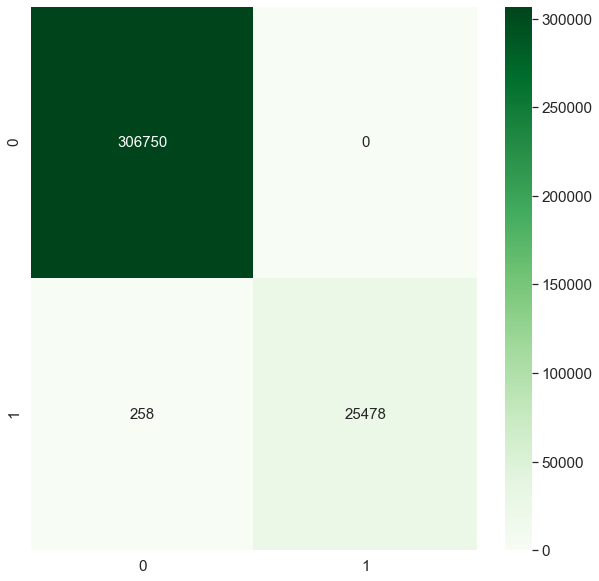

In [51]:
# show the confusion matrix

conf1= confusion_matrix(true_label1, yhat_c1)

df_cm = pd.DataFrame(conf1, range(2), range(2))
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g',cmap="Greens") # font size

plt.show()

ROC AUC score: 0.949694812945649


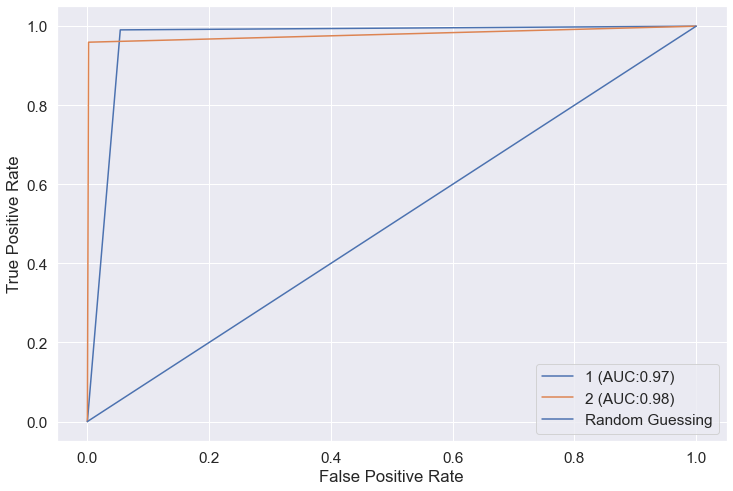

In [52]:
# Calculate ROC curve

target= [1,2]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y1_test, y1_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y1_test)
    y1_test = lb.transform(y1_test)
    y1_pred = lb.transform(y1_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y1_test[:,idx].astype(int), y1_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y1_test, y1_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


plt.show()
